In [1]:
from skeleton import *
from coco import KeyPoint
import matplotlib.pyplot as plt 
from model import *
import numpy as np

In [2]:
coco = Coco()
coco.load_annotations()

In [3]:
metadata_image = coco.get_metadata(6)
skeleton = Skeleton(
    img_shape=metadata_image['shape'],
    skeleton=metadata_image['skeleton'],
    keypoints=metadata_image['keypoints'],
    bbox=metadata_image['bbox'],
)
skeleton.sigma = 5

In [4]:
net = Net()
net.load_state_dict(torch.load('model.pt', map_location=torch.device('cpu'))['model'])
image = transforms.ToTensor()(Image.open(metadata_image['path']))

Using cache found in /home/brage/.cache/torch/hub/pytorch_vision_v0.10.0


In [5]:
if False:
    trainer = Trainer(net)
    trainer.single_step(
        image.reshape((1, ) + image.shape), 
        skeleton.confidence_map(),
        skeleton.paf_field(),
        get_annotation=lambda x: skeleton.annotation_map(x),
    )

In [6]:
def confidence_threshold(x):
    x[np.abs(x) < 0.1] = 0
    return x

In [7]:
confidence, paf = net(image.reshape((1, ) + image.shape))
keypoints = confidence.shape[1]


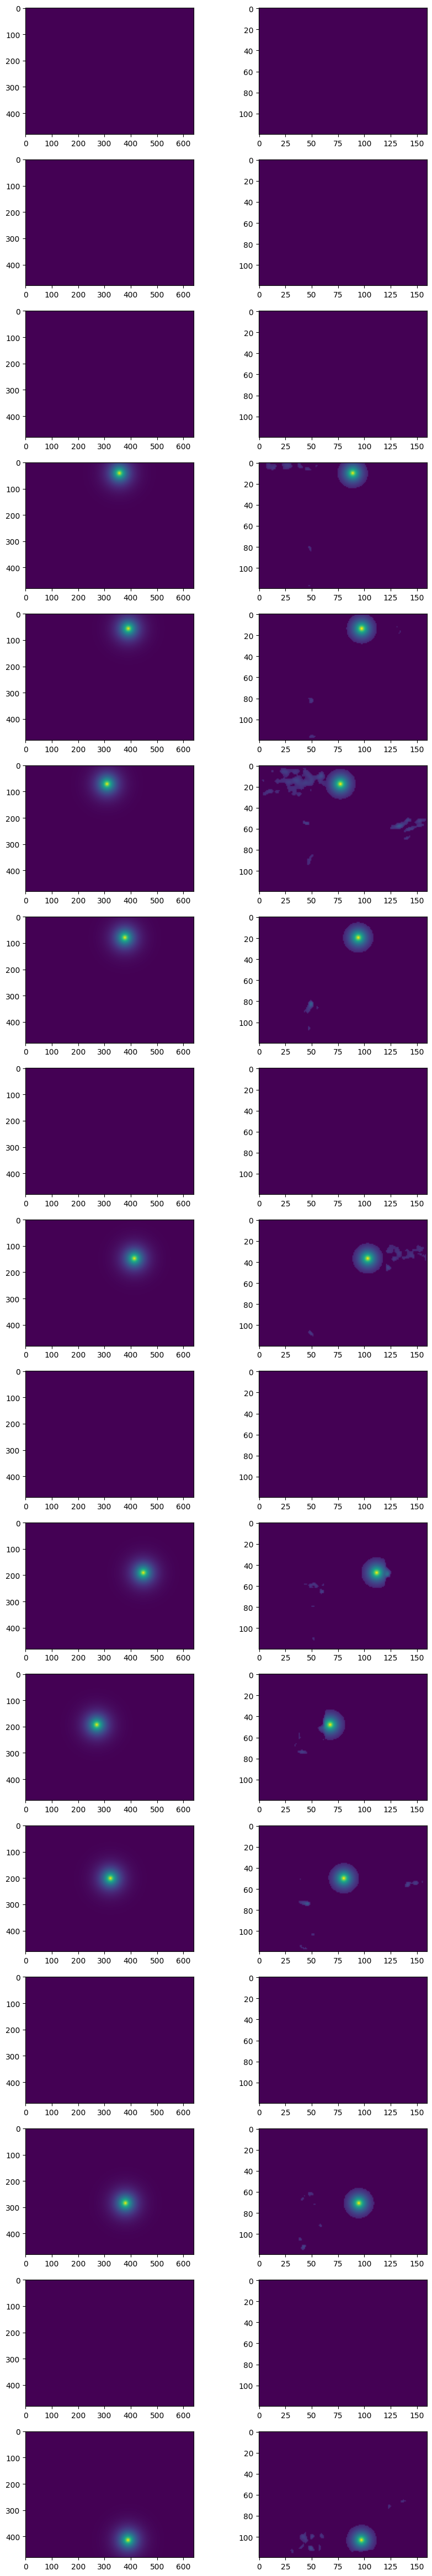

In [8]:
_, axarr = plt.subplots(keypoints, 2, figsize=(10,60))

for i in range(keypoints):
    axarr[i][0].imshow(skeleton.confidence_map()[i])
    axarr[i][1].imshow(confidence_threshold(confidence[0][i].detach().numpy()))

In [9]:
paf.shape

torch.Size([1, 38, 120, 160])

In [10]:
def merge_paf(predicted_paf, paf):
    merged = torch.zeros((paf.shape[0], 120, 160, 2))
    for i in range(paf.shape[0]):
        merged[i, :, :, 0] = (torch.abs(predicted_paf[0, 2 * i, :, :]).detach()).reshape((120, 160))
        merged[i, :, :, 1] = (torch.abs(predicted_paf[0, 2 * i + 1, :, :]).detach()).reshape((120, 160))
    return merged

In [11]:
paf_merged = merge_paf(
    paf,
    skeleton.paf_field()
)

In [12]:
def paf_threshold(x):
    x[np.abs(x) < 0.3] = 0
    return x

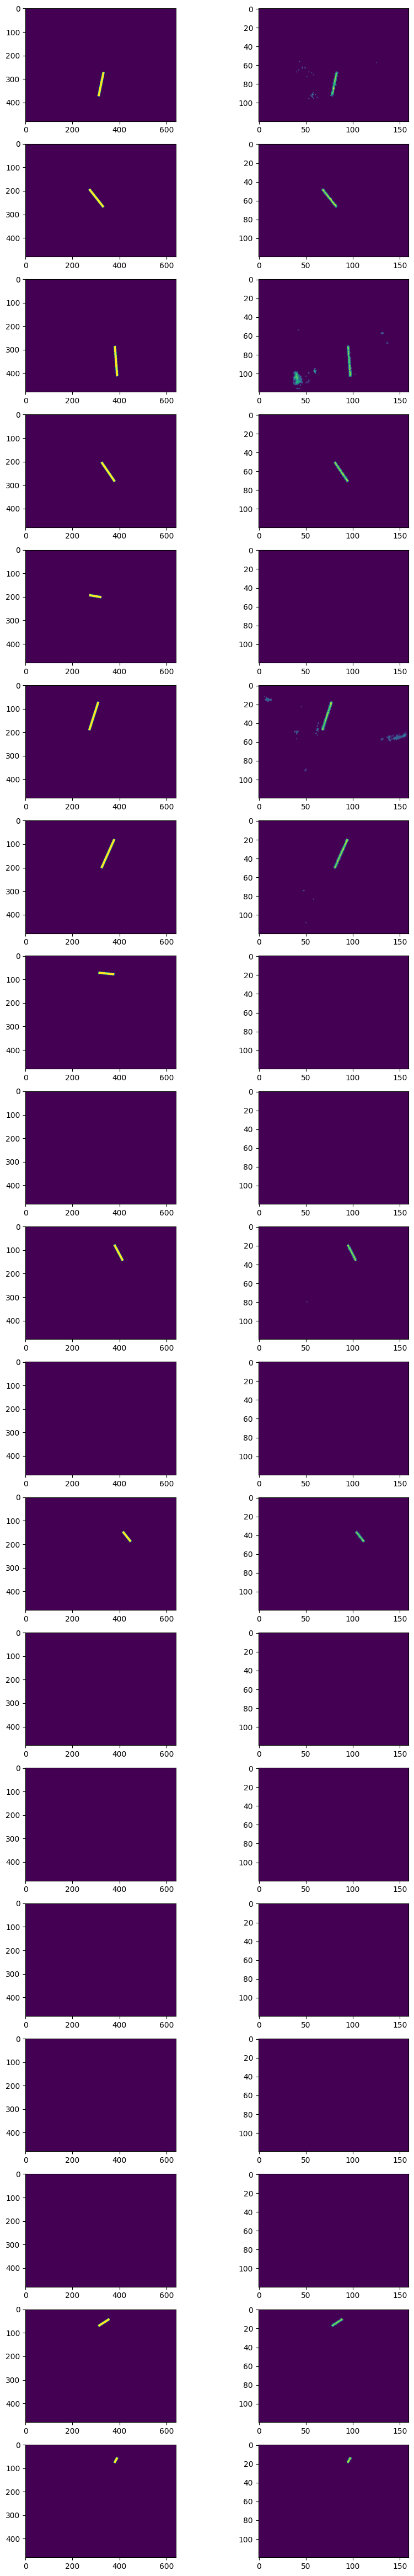

In [13]:
#print(paf.shape)
paf_points = paf.shape[1] // 2
_, axarr = plt.subplots(paf_points, 2, figsize=(10,60))

for limb in range(paf_points):
    predicted_paf = paf_merged[limb]
    predicted_paf = paf_threshold((torch.abs(predicted_paf)))[:, :, 0].float()
    
    truth_paf = skeleton.paf_field()
    truth_paf = ((truth_paf[limb] != 0) * 1)[:, :, 0].float().reshape((1, ) + metadata_image['shape'])


    axarr[limb][0].imshow(truth_paf[0])
    axarr[limb][1].imshow(predicted_paf)

## Mege 

In [14]:
print(paf_merged.shape)
print(confidence.shape)

torch.Size([19, 120, 160, 2])
torch.Size([1, 17, 120, 160])


In [15]:
predicted_confidence = F.interpolate(
    confidence, size=(480, 640), mode='bilinear')
predicted_paf = F.interpolate(
    paf_merged, size=(480, 640), mode='bilinear')
print(predicted_confidence.shape)
print(predicted_paf.shape)

torch.Size([1, 17, 480, 640])
torch.Size([19, 120, 480, 640])


### output 

In [16]:
confidence_thresholded = predicted_confidence[0].detach().numpy()#.clone()
for i in range(confidence_thresholded.shape[0]):
    confidence_thresholded[i] = confidence_threshold(confidence_thresholded[i])
confidence_thresholded = torch.from_numpy(confidence_thresholded)
print(confidence_thresholded.shape)

paf_thresholded = predicted_paf.detach().numpy()
for i in range(confidence_thresholded.shape[0]):
    paf_thresholded[i] = paf_threshold(paf_thresholded[i])
paf_thresholded = torch.from_numpy(paf_thresholded)

print(paf_thresholded.shape)
#predicted_paf_threadholded = torch.from_numpy()

torch.Size([17, 480, 640])
torch.Size([19, 120, 480, 640])


Need to fix the mapping

## Keypoints from model

index 0 is out of bounds for dimension 0 with size 0
index 0 is out of bounds for dimension 0 with size 0
index 0 is out of bounds for dimension 0 with size 0
index 0 is out of bounds for dimension 0 with size 0
index 0 is out of bounds for dimension 0 with size 0
index 0 is out of bounds for dimension 0 with size 0
index 0 is out of bounds for dimension 0 with size 0
index 0 is out of bounds for dimension 0 with size 0
index 0 is out of bounds for dimension 0 with size 0


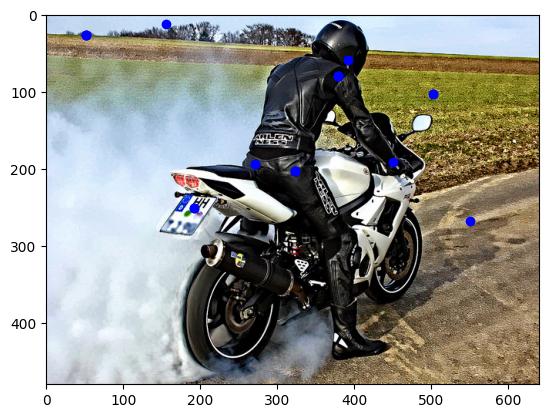

In [17]:
# Cool looks like this are kidna workign
items = list(skeleton.merge(
    # CURRENTLY DISABLED THRESHOLD
    confidence_thresholded if True else skeleton.confidence_map(), 
    paf_thresholded
))
coco.results[6].plot_image_skeleton_keypoints(items, draw_skeleton=False)

## True keypoints

index 0 is out of bounds for dimension 0 with size 0
index 0 is out of bounds for dimension 0 with size 0
index 0 is out of bounds for dimension 0 with size 0
index 0 is out of bounds for dimension 0 with size 0
index 0 is out of bounds for dimension 0 with size 0
index 0 is out of bounds for dimension 0 with size 0
index 0 is out of bounds for dimension 0 with size 0
index 0 is out of bounds for dimension 0 with size 0
index 0 is out of bounds for dimension 0 with size 0


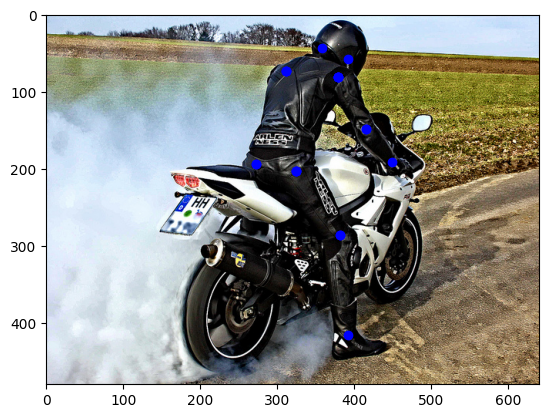

In [18]:
# Cool looks like this are kidna workign
items = list(skeleton.merge(
    # CURRENTLY DISABLED THRESHOLD
    confidence_thresholded if False else skeleton.confidence_map(), 
    paf_thresholded
))
coco.results[6].plot_image_skeleton_keypoints(items, draw_skeleton=False)

## Model skeleton (model confidence, model paf)

index 0 is out of bounds for dimension 0 with size 0
index 0 is out of bounds for dimension 0 with size 0
index 0 is out of bounds for dimension 0 with size 0
index 0 is out of bounds for dimension 0 with size 0
index 0 is out of bounds for dimension 0 with size 0
index 0 is out of bounds for dimension 0 with size 0
index 0 is out of bounds for dimension 0 with size 0
index 0 is out of bounds for dimension 0 with size 0
index 0 is out of bounds for dimension 0 with size 0


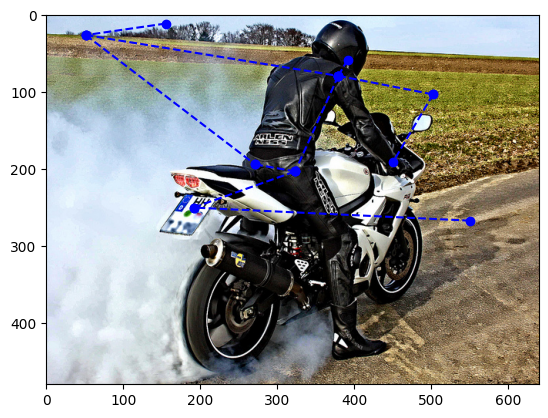

In [19]:
# Cool looks like this are kidna workign
items = list(skeleton.merge(
    confidence_thresholded, 
    paf_thresholded
))
coco.results[6].plot_image_skeleton_keypoints(items)

## Partial Model skeleton (true confidence, model paf)

Looks like bug is in how keypoints are extracted

index 0 is out of bounds for dimension 0 with size 0
index 0 is out of bounds for dimension 0 with size 0
index 0 is out of bounds for dimension 0 with size 0
index 0 is out of bounds for dimension 0 with size 0
index 0 is out of bounds for dimension 0 with size 0
index 0 is out of bounds for dimension 0 with size 0
index 0 is out of bounds for dimension 0 with size 0
index 0 is out of bounds for dimension 0 with size 0
index 0 is out of bounds for dimension 0 with size 0


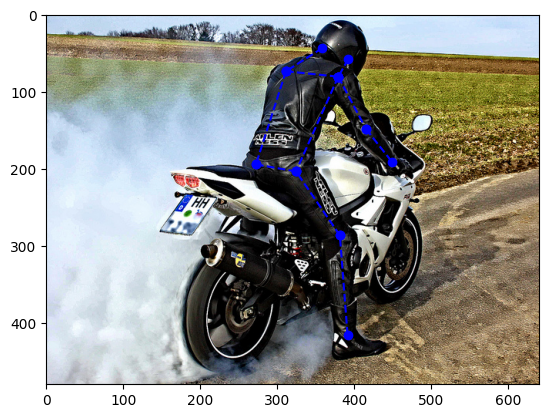

In [22]:
items = list(skeleton.merge(
    skeleton.confidence_map(), 
    paf_thresholded
))
coco.results[6].plot_image_skeleton_keypoints(items)

## True skeleton (merge confidence + paf)

index 0 is out of bounds for dimension 0 with size 0
index 0 is out of bounds for dimension 0 with size 0
index 0 is out of bounds for dimension 0 with size 0
index 0 is out of bounds for dimension 0 with size 0
index 0 is out of bounds for dimension 0 with size 0
index 0 is out of bounds for dimension 0 with size 0
index 0 is out of bounds for dimension 0 with size 0
index 0 is out of bounds for dimension 0 with size 0
index 0 is out of bounds for dimension 0 with size 0


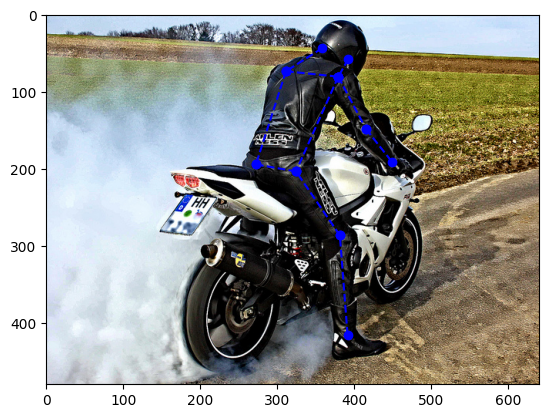

In [20]:
items = list(skeleton.merge(
    skeleton.confidence_map(), 
    skeleton.paf_field(), 
#    paf_thresholded
))
coco.results[6].plot_image_skeleton_keypoints(items)

## True skeleton (coco)

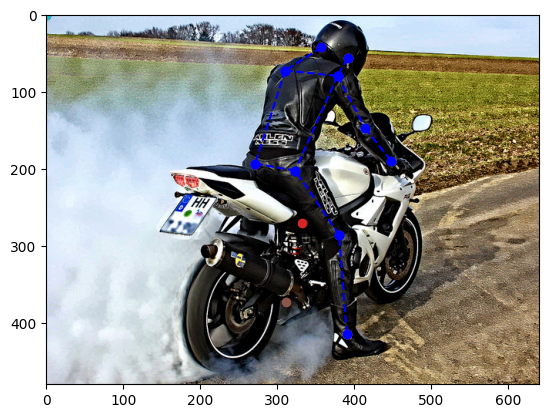

In [21]:
coco.results[6].imshow(
    skeleton=metadata_image['skeleton']
)